# Benchmarking cell2location pyro model using softplus/exp for scales using 5x larger data

In [1]:
import sys, ast, os
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib as mpl
data_type='float32'

import cell2location_model 

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

## Read datasets and train cell2location

Data can be downloaded as follows:

```bash
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/synth_adata_real_mg_20210131.h5ad
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/training_5705STDY8058280_5705STDY8058281_20210131.h5ad
```

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

In [3]:
# read synthetic data
adata_vis = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata_vis.uns['spatial'] = {'x': 'y'}
# select 5 samples (each with 2500 observations)
adata_vis = adata_vis[adata_vis.obs['sample'].isin([f'exper{i}' for i in range(5)]),:]

# read scRNA-seq data with reference cell types
adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [4]:
import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

In [5]:
adata_vis.X = scipy.sparse.csr_matrix(adata_vis.X)

Add counts matrix as `adata.raw` 

In [6]:
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

In [7]:
# compute average for each cluster
aver = cell2location_model.get_cluster_averages(adata_snrna_raw, 'annotation_1')

# make sure the order of gene matches between aver and x_data
aver = aver.loc[adata_vis.var_names,:]

# generate one-hot encoded matrix telling which obs belong to whic samples
obs2sample_df = pd.get_dummies(adata_vis.obs['sample'])

In [8]:
adata_vis

AnnData object with n_obs × n_vars = 12500 × 12809
    obs: 'cell_count_Inh_3', 'cell_count_Ext_Pir', 'cell_count_Oligo_2', 'cell_count_Astro_HYPO', 'cell_count_Ext_L25', 'cell_count_Astro_THAL_lat', 'cell_count_Ext_L5_1', 'cell_count_Ext_L23', 'cell_count_Micro', 'cell_count_Ext_Thal_1', 'cell_count_Ext_Hpc_CA1', 'cell_count_Inh_Meis2_3', 'cell_count_Inh_4', 'cell_count_OPC_1', 'cell_count_Oligo_1', 'cell_count_Ext_Hpc_CA3', 'cell_count_Astro_CTX', 'cell_count_Astro_THAL_med', 'cell_count_Inh_Vip', 'cell_count_Ext_Amy_2', 'cell_count_Astro_AMY_CTX', 'cell_count_Unk_1', 'cell_count_Inh_Sst', 'cell_count_Inh_Meis2_2', 'cell_count_Ext_Hpc_DG2', 'cell_count_Ext_Hpc_DG1', 'cell_count_Inh_1', 'cell_count_Inh_Meis2_4', 'cell_count_Inh_2', 'cell_count_Nb_1', 'cell_count_Ext_Thal_2', 'cell_count_Ext_Amy_1', 'cell_count_Ext_L6', 'cell_count_OPC_2', 'cell_count_Inh_Meis2_1', 'cell_count_Ext_L6B', 'cell_count_LowQ_2', 'cell_count_Ext_Unk_3', 'cell_count_Ext_L56', 'cell_count_Inh_Lamp5', 'cell_cou

## Model training

In [9]:
results_folder

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

In [10]:
#import torch
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

mod = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from pyro.distributions import constraints
mod.guide.scale_constraint = constraints.positive
#mod.guide.scale_constraint = constraints.softplus_positive

#mod.to('cuda')
mod._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                     obs2sample=obs2sample_df.values.astype(data_type),
                     n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

ValueError: Error while computing log_prob at site 'x_fr_group2fact':
The value argument must be within the support
               Trace Shapes:                    
                Param Sites:                    
               Sample Sites:                    
          m_g_alpha_hyp dist          |         
                       value          |         
                    log_prob          |         
           m_g_beta_hyp dist          |         
                       value          |         
                    log_prob          |         
                    m_g dist          |  1 12809
                       value          |  1 12809
                    log_prob          |         
 n_s_cells_per_location dist 12500  1 |         
                       value 12500  1 |         
                    log_prob 12500  1 |         
y_s_groups_per_location dist 12500  1 |         
                       value 12500  1 |         
                    log_prob 12500  1 |         
    z_sr_groups_factors dist 12500 50 |         
                       value 12500 50 |         
                    log_prob 12500 50 |         
 k_r_factors_per_groups dist          | 50     1
                       value          | 50     1
                    log_prob          |         
        x_fr_group2fact dist          | 50    49
                       value          | 50    49

In [ ]:
means = mod.guide.median()
means = {k: means[k].cpu().detach().numpy() 
         for k in means.keys()}

In [ ]:
means

In [12]:
mod_s = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from pyro.distributions import constraints
from pyro.distributions.transforms import SoftplusTransform
mod_s.guide.scale_constraint = constraints.softplus_positive

mod_s._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                    obs2sample=obs2sample_df.values.astype(data_type),
                    n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [13]:
means_softplus = mod_s.guide.median()
means_softplus = {k: means_softplus[k].cpu().detach().numpy() 
                  for k in means_softplus.keys()}
means_softplus

{'m_g_alpha_hyp': array(0.4314065, dtype=float32),
 'm_g_beta_hyp': array(1.4486576, dtype=float32),
 'm_g': array([[1.6425534e-03, 8.8124443e-07, 3.1476346e-01, ..., 3.5184238e-03,
         3.7792034e-02, 1.1889492e-01]], dtype=float32),
 'n_s_cells_per_location': array([[ 8.5972   ],
        [10.680841 ],
        [ 8.349849 ],
        ...,
        [ 7.6664987],
        [ 9.596103 ],
        [ 9.256251 ]], dtype=float32),
 'y_s_groups_per_location': array([[15.843332],
        [17.153126],
        [16.663568],
        ...,
        [17.126284],
        [17.437016],
        [16.565294]], dtype=float32),
 'z_sr_groups_factors': array([[0.04194633, 0.04001833, 0.0380566 , ..., 0.03908906, 0.03741352,
         0.04388533],
        [0.06541711, 0.06162256, 0.06414755, ..., 0.06541273, 0.05703141,
         0.06730314],
        [0.04280559, 0.04180336, 0.04149457, ..., 0.04397682, 0.04190159,
         0.04315544],
        ...,
        [0.03825556, 0.03664935, 0.03500321, ..., 0.04021983, 0.03

In [14]:
mod_s3 = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from pyro.distributions import constraints
from torch.distributions import biject_to, transform_to
@biject_to.register(constraints.positive)
@transform_to.register(constraints.positive)
def _transform_to_positive(constraint):
    return SoftplusTransform()

mod_s3.guide.scale_constraint = constraints.positive

mod_s3._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                    obs2sample=obs2sample_df.values.astype(data_type),
                    n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

### Compare ELBO as training progresses

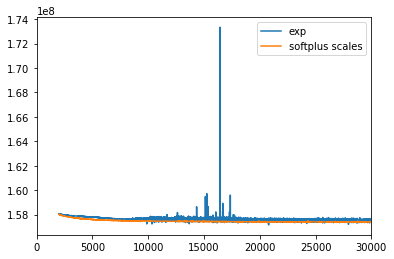

In [18]:
#plt.plot(range(2000, len(mod.hist)), np.array(mod.hist)[2000:]);
plt.plot(range(2000, len(mod_s.hist)), np.array(mod_s.hist)[2000:]);
plt.plot(range(2000, len(mod_s3.hist)), np.array(mod_s3.hist)[2000:]);
plt.legend(labels=['exp', 'softplus scales', 'all_softplus']);
plt.xlim(0, len(mod_s.hist));

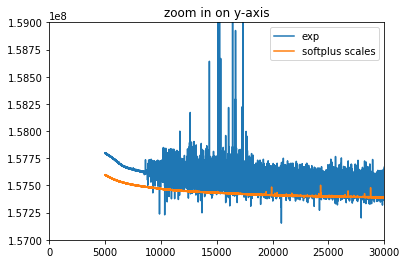

In [22]:
#plt.plot(range(5000, len(mod.hist)), np.array(mod.hist)[5000:]);
plt.plot(range(5000, len(mod_s.hist)), np.array(mod_s.hist)[5000:]);
plt.plot(range(5000, len(mod_s3.hist)), np.array(mod_s3.hist)[5000:]);
plt.legend(labels=['exp', 'softplus scales', 'all_softplus']);
plt.xlim(0, len(mod_s.hist));
plt.ylim(1.57e+8, 1.59e+8);
plt.title('zoom in on y-axis');

### Evaluate accuracy using $R^2$ with ground truth data

In [23]:
#means = mod.guide.median()
#means = {k: means[k].cpu().detach().numpy() 
#         for k in means.keys()}
means_softplus = mod_s.guide.median()
means_softplus = {k: means_softplus[k].cpu().detach().numpy() 
                  for k in means_softplus.keys()}
means_softplus_all = mod_s3.guide.median()
means_softplus_all = {k: means_softplus_all[k].cpu().detach().numpy() 
                  for k in means_softplus_all.keys()}

In [24]:
from re import sub
cell_count = adata_vis.obs.loc[:, ['cell_abundances_' in i for i in adata_vis.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns

#infer_cell_count = pd.DataFrame(means['w_sf'], index=adata_vis.obs_names, 
#                                columns=aver.columns)
#infer_cell_count = infer_cell_count[cell_count.columns]

infer_cell_count_softplus = pd.DataFrame(means_softplus['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count_softplus = infer_cell_count_softplus[cell_count.columns]

infer_cell_count_softplus_all = pd.DataFrame(means_softplus_all['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count_softplus_all = infer_cell_count_softplus_all[cell_count.columns]

In [25]:
#infer_cell_count.iloc[0:5,0:5], 
infer_cell_count_softplus.iloc[0:5,0:5], infer_cell_count_softplus_all.iloc[0:5,0:5]

(                      Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.196785  0.182704  0.081431    0.417659  0.353974
 exper0_location_1  0.081889  0.832802  0.100458    0.159647  0.107316
 exper0_location_2  0.120520  0.380786  0.033281    0.407470  0.262087
 exper0_location_3  0.174345  0.560751  0.361555    0.138572  0.170125
 exper0_location_4  0.122402  0.595210  0.275357    0.096312  0.102080,
                       Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.285900  0.317842  0.116482    0.619246  0.409572
 exper0_location_1  0.173409  1.315385  0.086756    0.227074  0.204582
 exper0_location_2  0.179651  0.553090  0.052360    0.602827  0.245014
 exper0_location_3  0.231140  0.811923  0.558741    0.070891  0.172032
 exper0_location_4  0.193234  0.866406  0.421636    0.117966  0.140964)

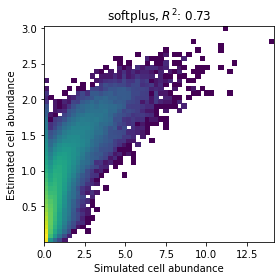

In [27]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count_softplus.values.flatten(),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'softplus, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count_softplus.values.flatten()), 3)[0,1]));
plt.tight_layout()

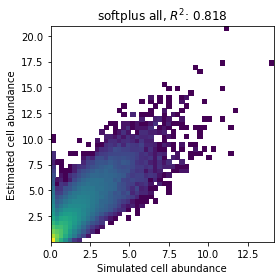

In [28]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count_softplus_all.values.flatten(),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'softplus all, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count_softplus_all.values.flatten()), 3)[0,1]));
plt.tight_layout()

Original implementation of cell2location in pymc3 has $R^2 = 0.791$.

## Evaluate with PR curves

In [29]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + '(' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=8))

    #plt.show()
    return roc

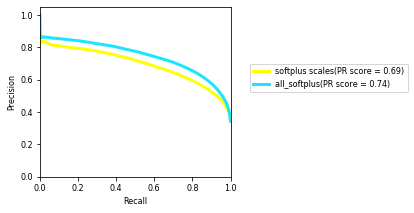

In [30]:
rcParams['figure.figsize'] = 6, 3
rcParams['font.size'] = 8

results = [
    #infer_cell_count,
    infer_cell_count_softplus,
    infer_cell_count_softplus_all
]

names = [
    #'exp', 
    'softplus scales', 
    'all_softplus'
]

compare_precision_recall(cell_count.values > 0.1, 
                         results,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()

Original implementation of cell2location in pymc3 has PR score = 0.66.

In [31]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.